In [101]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

In [107]:
data = pd.read_csv('ECONOMICS_USCSHPIMM, 1M.csv')


In [108]:
data.head()

,time,close
0,949363200,0.8
1,951868800,1.2
2,954547200,1.5
3,957139200,1.6
4,959817600,1.5


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    294 non-null    int64  
 1   close   294 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.7 KB


In [110]:
data.columns

Index(['time', 'close'], dtype='object')

In [111]:
data = data.drop('time',axis=1)

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   294 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


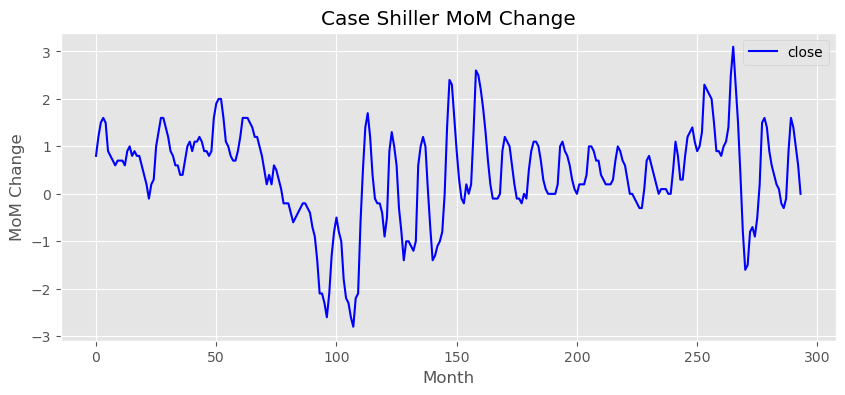

In [114]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change")
plt.show()

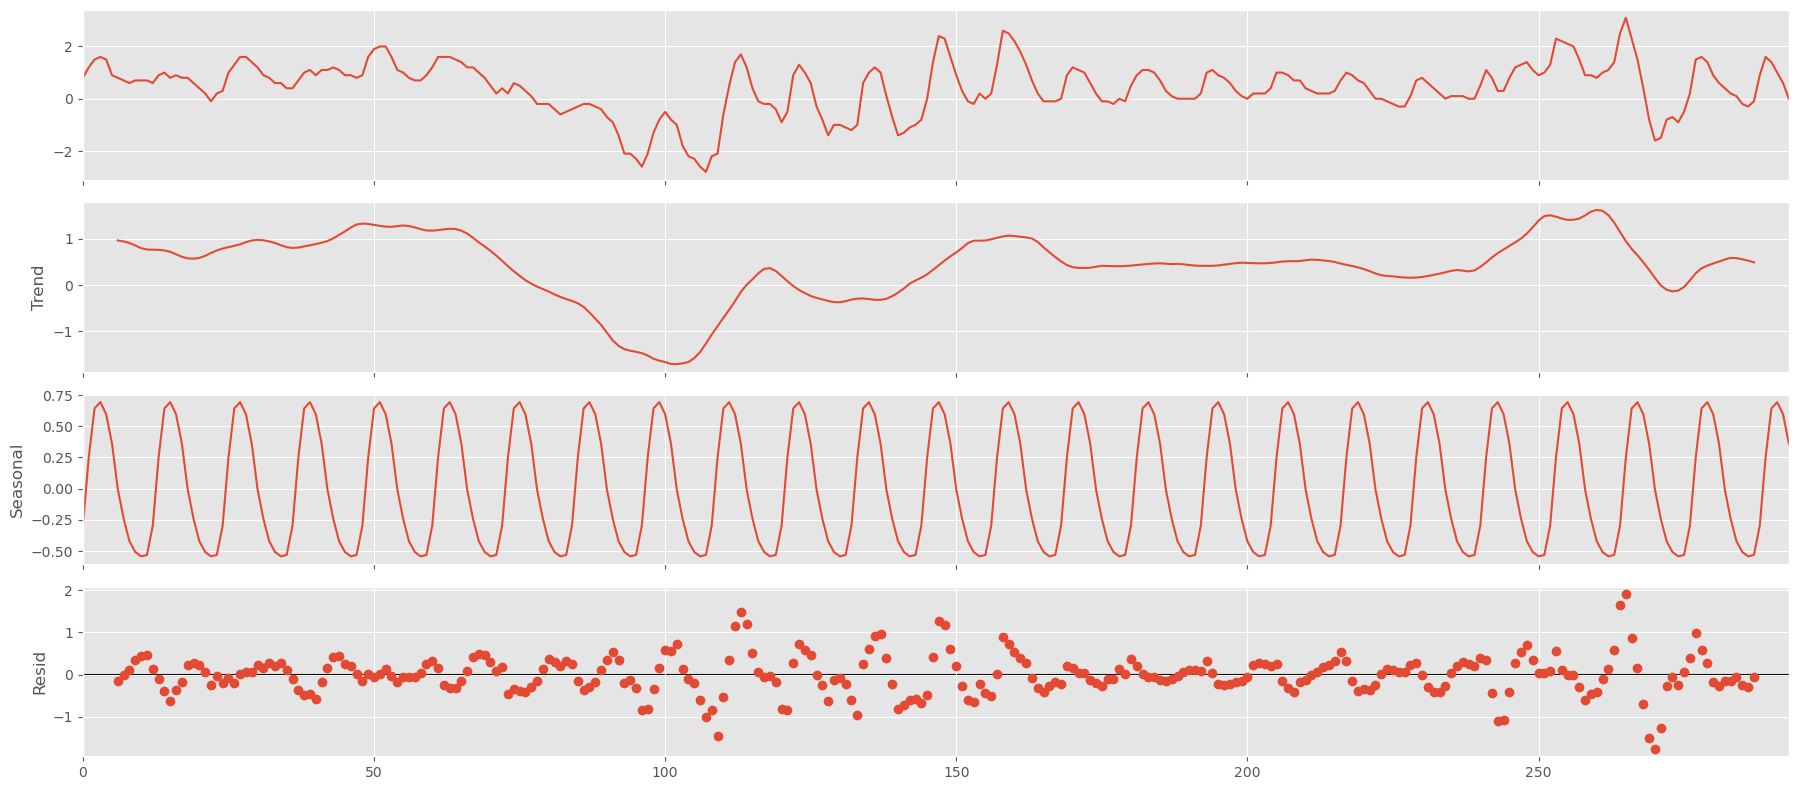

In [115]:
#Furniture sales time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period = 12)
fig = decomposition.plot()
plt.show()

In [116]:
data_raw = data.to_numpy()

In [117]:
# Normalize data to zero mean and unit variance
# scaler = StandardScalar()
# scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer()


data_scaled = scaler.fit_transform(data_raw)
# print(data_scaled)

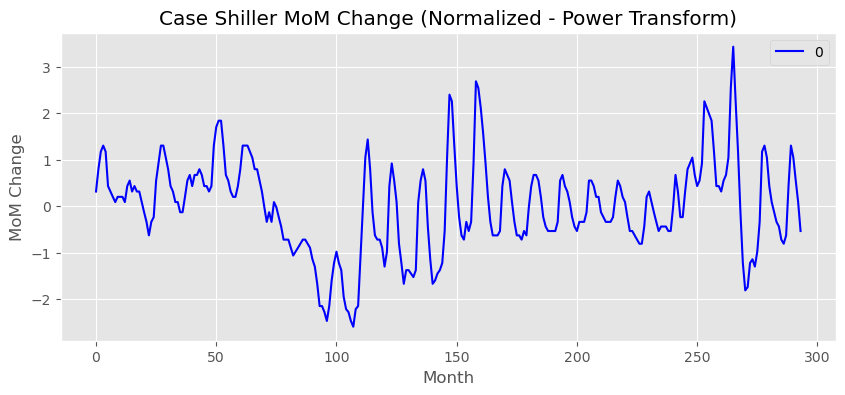

In [118]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change (Normalized - Power Transform)")
plt.show()

In [119]:
data_scaled.shape

(294, 1)

In [120]:
# Split data using 70/30 train/test split
split = round(len(data)*.7)

train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)

(206, 1)
(88, 1)


In [128]:
# Parameters
n_input = len(data) - split
n_features = 1
batch_size = 10
epochs = 150

# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32)

In [129]:
print(train_x.shape)
print(train_y.shape)

torch.Size([118, 88, 1])
torch.Size([118, 1])


In [130]:
# Dataset and DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [131]:
# Train the model
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [132]:
# Make future predictions - run just once
# Initialize and train the model
model = LSTMModel(n_input, n_features)
train_model(model, train_loader, epochs)

model.eval()
pred_list = []
batch = train_data[-n_input:].reshape((1, n_input, n_features))
batch = torch.tensor(batch, dtype=torch.float32)

with torch.no_grad():
    for i in range(n_input):
        pred = model(batch).item()
        pred_list.append(pred)
        batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

# Inverse transform the predictions
predicted_sales = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1))

# Create a dataframe for predictions
df_predict = pd.DataFrame(predicted_sales, index=data[-n_input:].index, columns=['Prediction'])

Epoch [25/150], Loss: 0.0848
Epoch [50/150], Loss: 0.0490
Epoch [75/150], Loss: 0.0598
Epoch [100/150], Loss: 0.0677
Epoch [125/150], Loss: 0.0586
Epoch [150/150], Loss: 0.0465


In [133]:
print(df_predict.shape)
print(df_predict)

(88, 1)
     Prediction
206    1.125496
207    1.056360
208    0.915552
209    0.740515
210    0.540523
..          ...
289   -6.495386
290   -6.487912
291   -6.480469
292   -6.473253
293   -6.466437

[88 rows x 1 columns]


In [134]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [135]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
n_runs = 3
store = np.zeros((n_input, n_runs))
model = LSTMModel(n_input, n_features)

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = LSTMModel(n_input, n_features)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

Epoch [25/150], Loss: 0.0605
Epoch [50/150], Loss: 0.0396
Epoch [75/150], Loss: 0.0325
Epoch [100/150], Loss: 0.0239
Epoch [125/150], Loss: 0.0263
Epoch [150/150], Loss: 0.0206
Epoch [25/150], Loss: 0.0759
Epoch [50/150], Loss: 0.0413
Epoch [75/150], Loss: 0.0553
Epoch [100/150], Loss: 0.0549
Epoch [125/150], Loss: 0.0378
Epoch [150/150], Loss: 0.0303
Epoch [25/150], Loss: 0.0485
Epoch [50/150], Loss: 0.0472
Epoch [75/150], Loss: 0.0399
Epoch [100/150], Loss: 0.0353
Epoch [125/150], Loss: 0.0405
Epoch [150/150], Loss: 0.0247


In [136]:
print(final_vanilla.shape)
print(final_vanilla)

(88,)
[ 1.18128992  1.06411844  0.85202806  0.49260845  0.17667194 -0.01599722
 -0.04005426 -0.04366497 -0.04321402  0.0734071   0.4882097   0.80108346
  0.85611537  0.83400201  0.60479122  0.20055338 -0.23122975 -0.3343712
 -0.42346302 -0.40896251 -0.35758951 -0.13520663  0.29567534  0.76767343
  0.94287367  0.83731632  0.52404069  0.08704553 -0.34779912 -0.58828955
 -0.48662366 -0.62377907 -0.53131141 -0.37115635 -0.06161356  0.46851
  1.10156366  1.28991467  0.99174871  0.56744093  0.10148533 -0.20980545
 -0.3143127  -0.28318205 -0.06334019  0.17061298  0.29329708  0.60042276
  1.07995536  1.19063443  0.89294438  0.45085573  0.09806265 -0.23814383
 -0.36399285 -0.12865855  0.18795959  0.46438901  0.44650406  0.50165686
  0.84477318  0.85238389  0.64982153  0.38270451  0.13801115 -0.05166778
 -0.27281154 -0.01376478  0.39000921  0.46011372  0.29443556  0.12821853
  0.43190275  0.69761903  0.68840026  0.54087107  0.24708631 -0.15026968
 -0.17198339  0.18792676  0.44517968  0.57847868 

In [137]:
len(data)

294

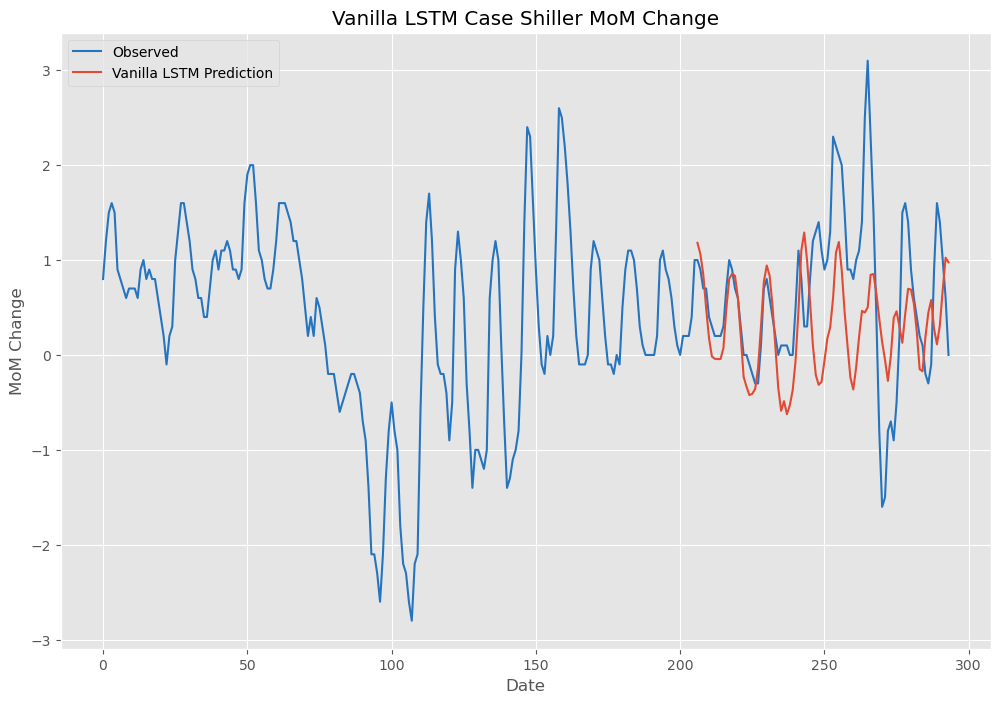

In [139]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM Case Shiller MoM Change')
plt.xlabel('Date')
plt.ylabel('MoM Change')
plt.legend()
plt.show()